<a href="https://colab.research.google.com/github/GheneaCostin/Simplified-CFD-Aerodynamics-Simulation-Airflow-Around-a-Wing-/blob/main/Simplified_CFD_Aerodynamics_Simulation_(Airflow_Around_a_Wing).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import matplotlib.pyplot as plt


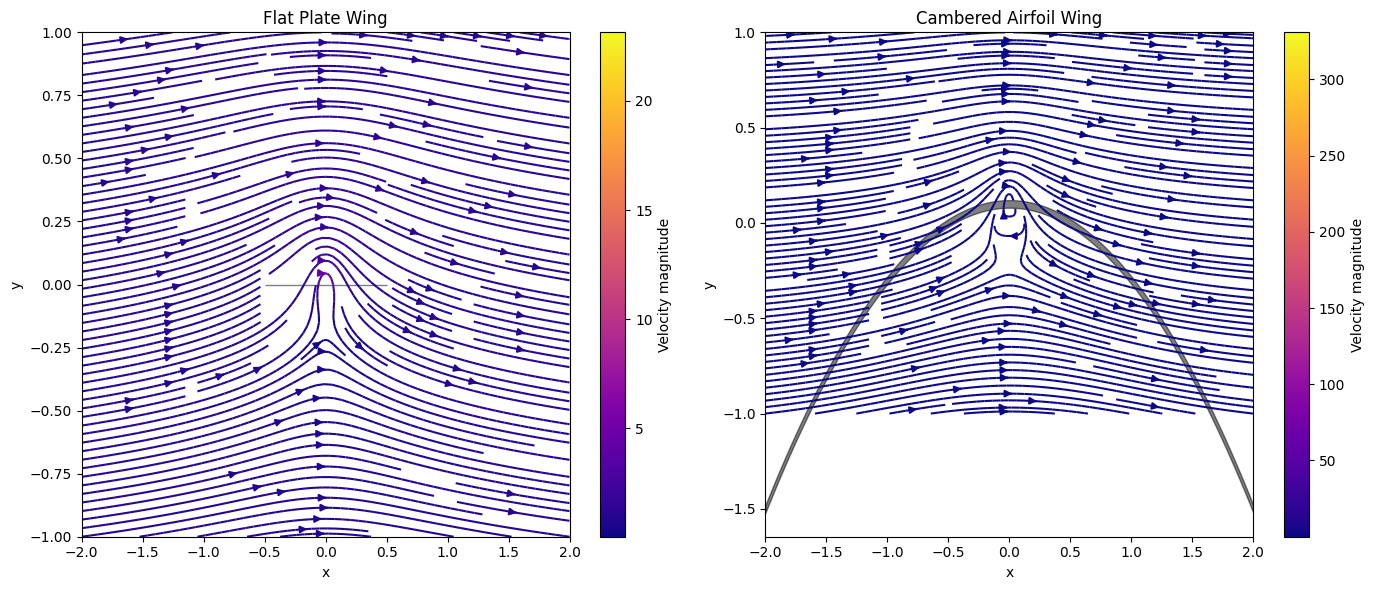

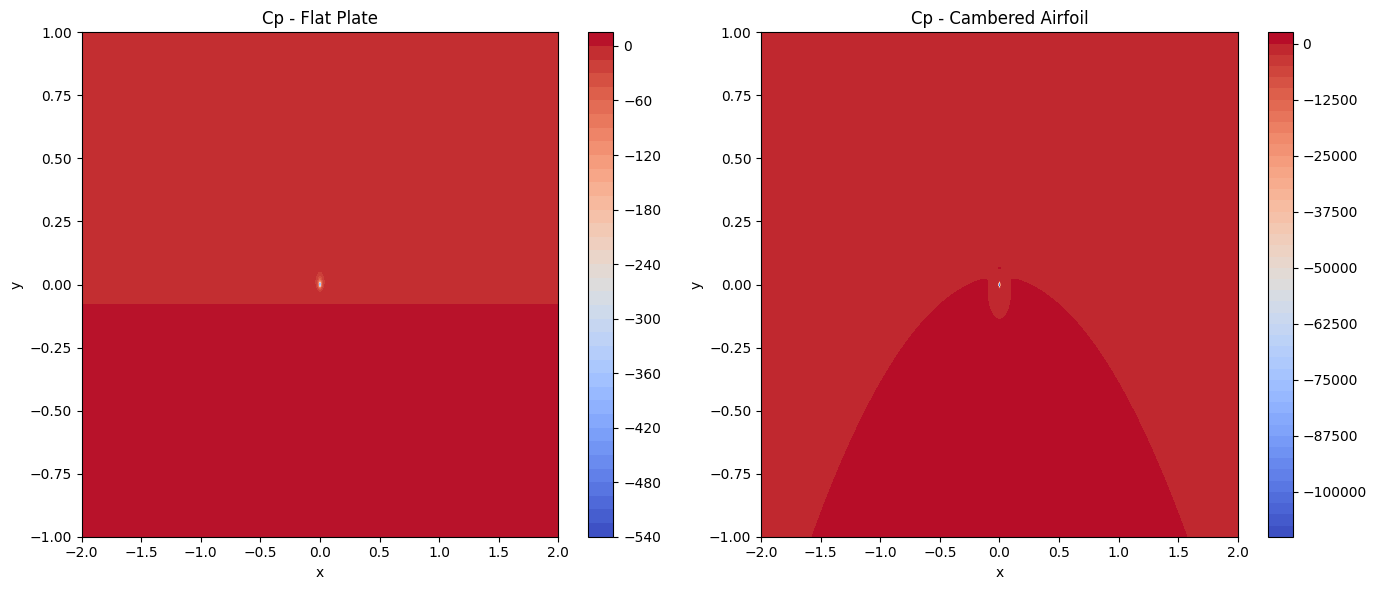

In [16]:

# -------------------------
# Parameters
# -------------------------
U_inf = 1.0  # Freestream velocity
x = np.linspace(-2, 2, 400)
y = np.linspace(-1, 1, 200)
X, Y = np.meshgrid(x, y)

# -------------------------
# Flat plate wing (y=0)
# -------------------------
gamma = 1.0  # vortex strength
x0, y0 = 0.0, 0.0

u_flat = U_inf + gamma/(2*np.pi) * (Y - y0)/((X - x0)**2 + (Y - y0)**2)
v_flat = - gamma/(2*np.pi) * (X - x0)/((X - x0)**2 + (Y - y0)**2)
V_flat = np.sqrt(u_flat**2 + v_flat**2)
Cp_flat = 1 - (V_flat/U_inf)**2  # approximate pressure coefficient

# -------------------------
# Cambered airfoil (simple parabolic camber)
# -------------------------
camber = 0.1  # max camber
y_camber = camber * (1 - (X/0.5)**2)  # simple parabolic camber centered at 0
u_camber = U_inf + gamma/(2*np.pi) * (Y - y_camber)/((X - x0)**2 + (Y - y0)**2)
v_camber = - gamma/(2*np.pi) * (X - x0)/((X - x0)**2 + (Y - y_camber)**2)
V_camber = np.sqrt(u_camber**2 + v_camber**2)
Cp_camber = 1 - (V_camber/U_inf)**2

# -------------------------
# Plot Streamlines
# -------------------------
fig, axes = plt.subplots(1, 2, figsize=(14,6))

# Flat plate
ax = axes[0]
strm = ax.streamplot(X, Y, u_flat, v_flat, density=2, color=V_flat, cmap='plasma')
ax.fill_between([-0.5, 0.5], 0, 0, color='k', alpha=0.5)
ax.set_title("Flat Plate Wing")
ax.set_xlabel("x")
ax.set_ylabel("y")
fig.colorbar(strm.lines, ax=ax, label='Velocity magnitude')

# Cambered airfoil
ax = axes[1]
strm = ax.streamplot(X, Y, u_camber, v_camber, density=2, color=V_camber, cmap='plasma')
ax.fill_between(X[0], y_camber[0]-0.02, y_camber[0]+0.02, color='k', alpha=0.5)
ax.set_title("Cambered Airfoil Wing")
ax.set_xlabel("x")
ax.set_ylabel("y")
fig.colorbar(strm.lines, ax=ax, label='Velocity magnitude')

plt.tight_layout()
plt.show()

# -------------------------
# Plot Pressure Coefficient Cp
# -------------------------
fig, axes = plt.subplots(1, 2, figsize=(14,6))
c1 = axes[0].contourf(X, Y, Cp_flat, levels=50, cmap='coolwarm')
axes[0].set_title("Cp - Flat Plate")
axes[0].set_xlabel("x")
axes[0].set_ylabel("y")
fig.colorbar(c1, ax=axes[0])

c2 = axes[1].contourf(X, Y, Cp_camber, levels=50, cmap='coolwarm')
axes[1].set_title("Cp - Cambered Airfoil")
axes[1].set_xlabel("x")
axes[1].set_ylabel("y")
fig.colorbar(c2, ax=axes[1])

plt.tight_layout()
plt.show()


In [17]:
def naca4_airfoil(code, n_points=200, alpha=0.0):
    """
    Generate x,y coordinates for a NACA 4-digit airfoil.
    code: string, e.g., '2412'
    n_points: number of points per surface
    alpha: angle of attack in degrees
    """
    m = int(code[0]) / 100.0      # maximum camber
    p = int(code[1]) / 10.0       # location of maximum camber
    t = int(code[2:]) / 100.0     # thickness

    # Cosine-spaced x
    beta = np.linspace(0, np.pi, n_points)
    x = (1 - np.cos(beta)) / 2

    # Thickness distribution
    yt = 5 * t * (0.2969*np.sqrt(x) - 0.1260*x - 0.3516*x**2 + 0.2843*x**3 - 0.1015*x**4)

    # Camber line
    yc = np.zeros_like(x)
    dyc_dx = np.zeros_like(x)
    for i in range(n_points):
        if x[i] < p and p != 0:
            yc[i] = m / (p**2) * (2*p*x[i] - x[i]**2)
            dyc_dx[i] = 2*m / (p**2) * (p - x[i])
        elif p != 0:
            yc[i] = m / ((1 - p)**2) * ((1 - 2*p) + 2*p*x[i] - x[i]**2)
            dyc_dx[i] = 2*m / ((1 - p)**2) * (p - x[i])
        else:
            yc[i] = 0
            dyc_dx[i] = 0

    theta = np.arctan(dyc_dx)

    # Upper and lower surfaces
    xu = x - yt*np.sin(theta)
    yu = yc + yt*np.cos(theta)
    xl = x + yt*np.sin(theta)
    yl = yc - yt*np.cos(theta)

    # Apply angle of attack rotation
    alpha_rad = np.radians(alpha)
    xu_rot = xu*np.cos(alpha_rad) - yu*np.sin(alpha_rad)
    yu_rot = xu*np.sin(alpha_rad) + yu*np.cos(alpha_rad)
    xl_rot = xl*np.cos(alpha_rad) - yl*np.sin(alpha_rad)
    yl_rot = xl*np.sin(alpha_rad) + yl*np.cos(alpha_rad)

    return xu_rot, yu_rot, xl_rot, yl_rot

In [18]:
def plot_airfoil_flow(xu, yu, xl, yl, U_inf=1.0, gamma=1.0, title="Airfoil Flow"):
    # Simple vortex at midpoint (for demo)
    x0, y0 = 0.5, 0.0
    X, Y = np.meshgrid(np.linspace(-1, 2, 400), np.linspace(-1, 1, 200))
    u = U_inf + gamma/(2*np.pi) * (Y - y0)/((X - x0)**2 + (Y - y0)**2)
    v = - gamma/(2*np.pi) * (X - x0)/((X - x0)**2 + (Y - y0)**2)
    V = np.sqrt(u**2 + v**2)

    plt.figure(figsize=(10,5))
    strm = plt.streamplot(X, Y, u, v, density=2, color=V, cmap='plasma')
    plt.fill_between(xu, yu-0.001, yu+0.001, color='k', alpha=0.7)
    plt.fill_between(xl, yl-0.001, yl+0.001, color='k', alpha=0.7)
    plt.title(title)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.colorbar(strm.lines, label='Velocity magnitude')
    plt.show()


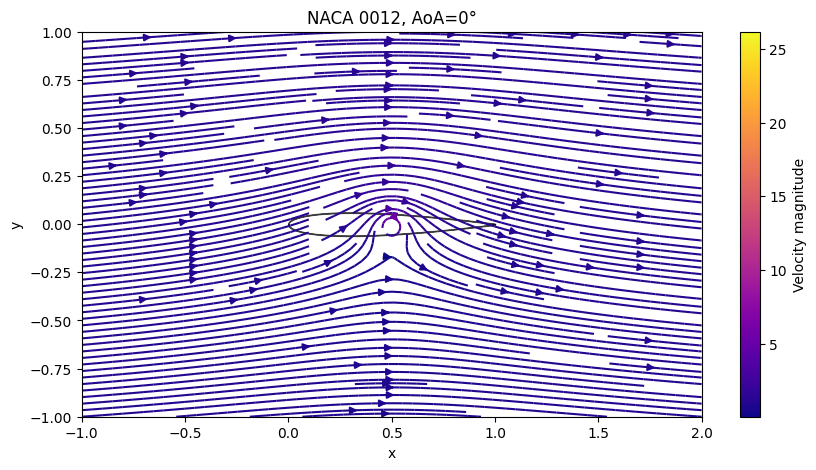

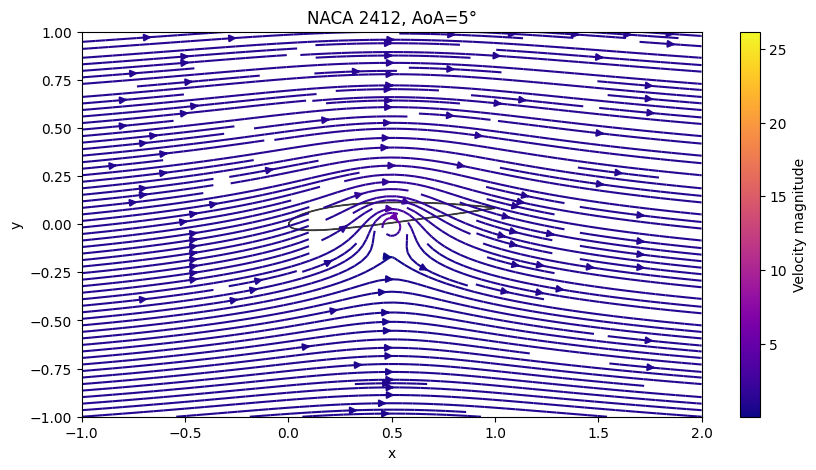

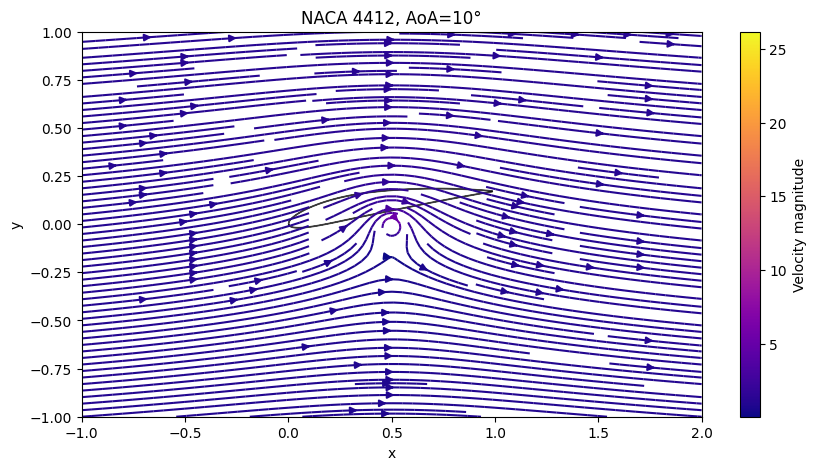

In [19]:
# Define multiple airfoils and angles
airfoils = [("0012", 0), ("2412", 5), ("4412", 10)]

for code, alpha in airfoils:
    xu, yu, xl, yl = naca4_airfoil(code, alpha=alpha)
    plot_airfoil_flow(xu, yu, xl, yl, title=f"NACA {code}, AoA={alpha}°")


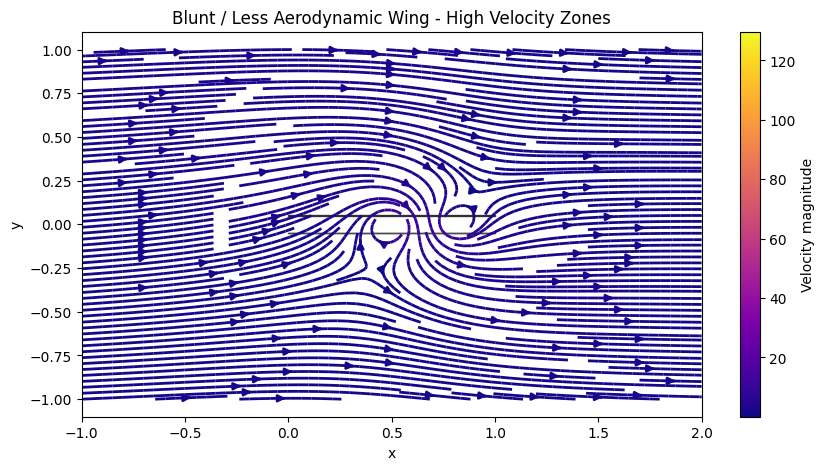

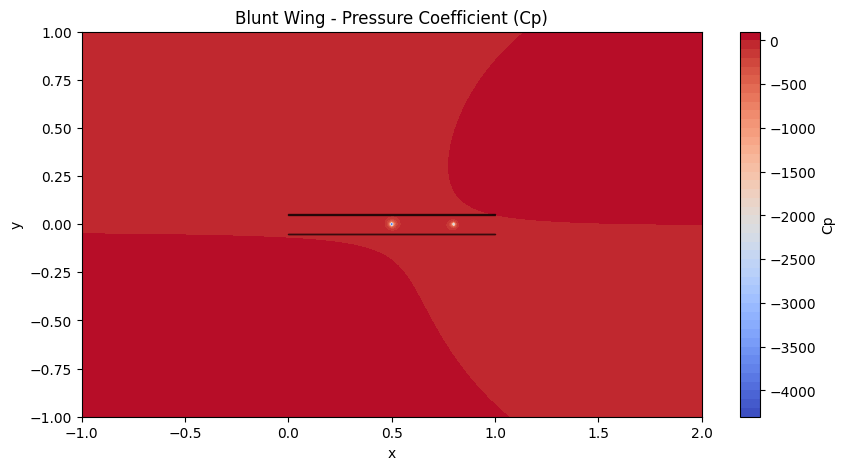

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# -------------------------
# Grid
# -------------------------
X, Y = np.meshgrid(np.linspace(-1, 2, 400), np.linspace(-1, 1, 200))

# -------------------------
# Multi-vortex potential flow for higher velocity
# -------------------------
def potential_flow_multi(X, Y, U_inf=2.0):
    # Two vortices to create higher velocity zones
    gamma1, gamma2 = 5.0, -4.0
    x1, y1 = 0.5, 0.0
    x2, y2 = 0.8, 0.0

    u = U_inf \
        + gamma1/(2*np.pi)*(Y - y1)/((X - x1)**2 + (Y - y1)**2) \
        + gamma2/(2*np.pi)*(Y - y2)/((X - x2)**2 + (Y - y2)**2)
    v = - gamma1/(2*np.pi)*(X - x1)/((X - x1)**2 + (Y - y1)**2) \
        - gamma2/(2*np.pi)*(X - x2)/((X - x2)**2 + (Y - y2)**2)
    V = np.sqrt(u**2 + v**2)
    Cp = 1 - (V/U_inf)**2
    return u, v, V, Cp

# -------------------------
# Blunt wing
# -------------------------
def blunt_airfoil():
    x = np.linspace(0, 1, 100)
    y_upper = 0.05 * np.ones_like(x)
    y_lower = -0.05 * np.ones_like(x)
    return x, y_upper, x, y_lower

# -------------------------
# Compute flow
# -------------------------
x_u, y_u, x_l, y_l = blunt_airfoil()
u, v, V, Cp = potential_flow_multi(X, Y)

# -------------------------
# Streamline plot
# -------------------------
plt.figure(figsize=(10,5))
strm = plt.streamplot(X, Y, u, v, density=2, color=V, cmap='plasma', linewidth=2)
plt.fill_between(x_u, y_u-0.001, y_u+0.001, color='k', alpha=0.7)
plt.fill_between(x_l, y_l-0.001, y_l+0.001, color='k', alpha=0.7)
plt.title("Blunt / Less Aerodynamic Wing - High Velocity Zones")
plt.xlabel("x")
plt.ylabel("y")
plt.colorbar(strm.lines, label='Velocity magnitude')
plt.show()

# -------------------------
# Pressure coefficient plot
# -------------------------
plt.figure(figsize=(10,5))
cp_plot = plt.contourf(X, Y, Cp, levels=50, cmap='coolwarm')
plt.fill_between(x_u, y_u-0.001, y_u+0.001, color='k', alpha=0.7)
plt.fill_between(x_l, y_l-0.001, y_l+0.001, color='k', alpha=0.7)
plt.title("Blunt Wing - Pressure Coefficient (Cp)")
plt.xlabel("x")
plt.ylabel("y")
plt.colorbar(cp_plot, label='Cp')
plt.show()
